In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
%cd /content/drive/Shared\ drives/Covid-19/

/content/drive/Shared drives/Covid-19


In [2]:
!pip install geopandas

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_log_error

from datetime import datetime
from datetime import timedelta

from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Dataset-1**

In [5]:
dataset = gpd.read_file("datasets/train.csv")
dataset["ConfirmedCases"] = dataset["ConfirmedCases"].astype("float")
dataset["Fatalities"] = dataset["Fatalities"].astype("float")
dataset["Country_Region"] = [ row.Country_Region.replace("'","").strip(" ") if row.Province_State=="" else str(row.Country_Region+"_"+row.Province_State).replace("'","").strip(" ") for idx,row in dataset.iterrows()]
dataset.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,geometry
0,1,,Afghanistan,2020-01-22,0.0,0.0,None
1,2,,Afghanistan,2020-01-23,0.0,0.0,None
2,3,,Afghanistan,2020-01-24,0.0,0.0,None
3,4,,Afghanistan,2020-01-25,0.0,0.0,None
4,5,,Afghanistan,2020-01-26,0.0,0.0,None


### **Dataset-2**

In [6]:
enhanced_dataset = gpd.read_file("datasets/enhanced_covid_19.csv")
enhanced_dataset["Country_Region"] = [country_name.replace("'","") for country_name in enhanced_dataset["Country_Region"]]
# enhanced_dataset["restrictions"] = enhanced_dataset["restrictions"].astype("int")
enhanced_dataset["quarantine"] = enhanced_dataset["quarantine"].astype("int")
enhanced_dataset["schools"] = enhanced_dataset["schools"].astype("int")
enhanced_dataset["total_pop"] = enhanced_dataset["total_pop"].astype("float")
enhanced_dataset["density"] = enhanced_dataset["density"].astype("float")
enhanced_dataset["hospibed"] = enhanced_dataset["hospibed"].astype("float")
enhanced_dataset["lung"] = enhanced_dataset["lung"].astype("float")
enhanced_dataset["smokers_perc"] = enhanced_dataset["smokers_perc"].astype("float")
enhanced_dataset["smokers_perc"] = enhanced_dataset["smokers_perc"]/100.0
enhanced_dataset["total_pop"] = enhanced_dataset["total_pop"]/max(enhanced_dataset["total_pop"])
enhanced_dataset["density"] = enhanced_dataset["density"]/max(enhanced_dataset["density"])
enhanced_dataset["hospibed"] = enhanced_dataset["hospibed"]/max(enhanced_dataset["hospibed"])
enhanced_dataset["lung"] = enhanced_dataset["lung"]/max(enhanced_dataset["lung"])
enhanced_dataset["age_100+"] = enhanced_dataset["age_100+"].astype("float")
enhanced_dataset["age_100+"] = enhanced_dataset["age_100+"]/max(enhanced_dataset["age_100+"])
enhanced_dataset = enhanced_dataset[["Country_Region","Date","quarantine","schools","hospibed","lung","total_pop","density","age_100+", "smokers_perc"]]
enhanced_dataset.head()

,Country_Region,Date,quarantine,schools,hospibed,lung,total_pop,density,age_100+,smokers_perc
0,Afghanistan,2020-01-22,0,0,0.034835,0.329191,0.027046,0.002278,0.001411,0.213894
1,Afghanistan,2020-01-23,0,0,0.034835,0.329191,0.027046,0.002278,0.001411,0.213894
2,Afghanistan,2020-01-24,0,0,0.034835,0.329191,0.027046,0.002278,0.001411,0.213894
3,Afghanistan,2020-01-25,0,0,0.034835,0.329191,0.027046,0.002278,0.001411,0.213894
4,Afghanistan,2020-01-26,0,0,0.034835,0.329191,0.027046,0.002278,0.001411,0.213894


### **Merge Dataset**

In [7]:
merge_dataset = dataset.merge(enhanced_dataset,how="left", on=["Country_Region","Date"]).drop_duplicates()
merge_dataset.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,geometry,quarantine,schools,hospibed,lung,total_pop,density,age_100+,smokers_perc
0,1,,Afghanistan,2020-01-22,0.0,0.0,None,0.0,0.0,0.034835,0.329191,0.027046,0.002278,0.001411,0.213894
1,2,,Afghanistan,2020-01-23,0.0,0.0,None,0.0,0.0,0.034835,0.329191,0.027046,0.002278,0.001411,0.213894
2,3,,Afghanistan,2020-01-24,0.0,0.0,None,0.0,0.0,0.034835,0.329191,0.027046,0.002278,0.001411,0.213894
3,4,,Afghanistan,2020-01-25,0.0,0.0,None,0.0,0.0,0.034835,0.329191,0.027046,0.002278,0.001411,0.213894
4,5,,Afghanistan,2020-01-26,0.0,0.0,None,0.0,0.0,0.034835,0.329191,0.027046,0.002278,0.001411,0.213894


### **Replacing data with 25th March dataset**

In [0]:
for country_region in merge_dataset.Country_Region.unique():
    query_df = merge_dataset.query("Country_Region=='"+country_region+"' and Date=='2020-03-25'")
    merge_dataset.loc[(merge_dataset["Country_Region"]==country_region) & (merge_dataset["Date"]>"2020-03-25"),"total_pop"] = query_df.total_pop.values[0]
    merge_dataset.loc[(merge_dataset["Country_Region"]==country_region) & (merge_dataset["Date"]>"2020-03-25"),"hospibed"] = query_df.hospibed.values[0]
    merge_dataset.loc[(merge_dataset["Country_Region"]==country_region) & (merge_dataset["Date"]>"2020-03-25"),"density"] = query_df.density.values[0]
    merge_dataset.loc[(merge_dataset["Country_Region"]==country_region) & (merge_dataset["Date"]>"2020-03-25"),"lung"] = query_df.lung.values[0]
    merge_dataset.loc[(merge_dataset["Country_Region"]==country_region) & (merge_dataset["Date"]>"2020-03-25"),"age_100+"] = query_df["age_100+"].values[0]
    # merge_dataset.loc[(merge_dataset["Country_Region"]==country_region) & (merge_dataset["Date"]>"2020-03-25"),"restrictions"] = query_df.restrictions.values[0]
    merge_dataset.loc[(merge_dataset["Country_Region"]==country_region) & (merge_dataset["Date"]>"2020-03-25"),"quarantine"] = query_df.quarantine.values[0]
    merge_dataset.loc[(merge_dataset["Country_Region"]==country_region) & (merge_dataset["Date"]>"2020-03-25"),"schools"] = query_df.schools.values[0]
    merge_dataset.loc[(merge_dataset["Country_Region"]==country_region) & (merge_dataset["Date"]>"2020-03-25"),"smokers_perc"] = query_df.smokers_perc.values[0]

### **Replacing Null Values with the median values**

In [9]:

median_pop = np.median(enhanced_dataset.total_pop)
median_hospibed = np.median(enhanced_dataset.hospibed)
median_density = np.median(enhanced_dataset.density)
median_lung = np.median(enhanced_dataset.lung)
median_centenarian_pop = np.median(enhanced_dataset["age_100+"])
median_smokers_perc = np.median(enhanced_dataset["smokers_perc"])
#need to replace that with a joint using Pandas
print("The missing countries/region are:")
for country_region in merge_dataset.Country_Region.unique():
    if enhanced_dataset.query("Country_Region=='"+country_region+"'").empty:
        print(country_region)
        
        merge_dataset.loc[merge_dataset["Country_Region"]==country_region,"total_pop"] = median_pop
        merge_dataset.loc[merge_dataset["Country_Region"]==country_region,"hospibed"] = median_hospibed
        merge_dataset.loc[merge_dataset["Country_Region"]==country_region,"density"] = median_density
        merge_dataset.loc[merge_dataset["Country_Region"]==country_region,"lung"] = median_lung
        merge_dataset.loc[merge_dataset["Country_Region"]==country_region,"age_100+"] = median_centenarian_pop
        # merge_dataset.loc[merge_dataset["Country_Region"]==country_region,"restrictions"] = 0
        merge_dataset.loc[merge_dataset["Country_Region"]==country_region,"quarantine"] = 0
        merge_dataset.loc[merge_dataset["Country_Region"]==country_region,"schools"] = 0
        merge_dataset.loc[merge_dataset["Country_Region"]==country_region,"smokers_perc"] = median_smokers_perc

The missing countries/region are:
Australia_Australian Capital Territory
Australia_New South Wales
Australia_Northern Territory
Australia_Queensland
Australia_South Australia
Australia_Tasmania
Australia_Victoria
Australia_Western Australia
Canada_Alberta
Canada_British Columbia
Canada_Manitoba
Canada_New Brunswick
Canada_Newfoundland and Labrador
Canada_Northwest Territories
Canada_Nova Scotia
Canada_Ontario
Canada_Prince Edward Island
Canada_Quebec
Canada_Saskatchewan
Canada_Yukon
China_Anhui
China_Beijing
China_Chongqing
China_Fujian
China_Gansu
China_Guangdong
China_Guangxi
China_Guizhou
China_Hainan
China_Hebei
China_Heilongjiang
China_Henan
China_Hong Kong
China_Hubei
China_Hunan
China_Inner Mongolia
China_Jiangsu
China_Jiangxi
China_Jilin
China_Liaoning
China_Macau
China_Ningxia
China_Qinghai
China_Shaanxi
China_Shandong
China_Shanghai
China_Shanxi
China_Sichuan
China_Tianjin
China_Tibet
China_Xinjiang
China_Yunnan
China_Zhejiang
Denmark_Faroe Islands
Denmark_Greenland
France_Fr

In [0]:
#Makes it easier to generate the sequences
def prepareDataSet(train_df, startDate, endDate, days_in_sequence):
  # train_df = train_df.query("Date>'2020-01-22'and Date<'2020-04-01'")
  train_df = train_df.copy()
  train_df = train_df.query("Date> '"+startDate+"' and Date<'"+endDate+"'")
  print(train_df.shape)
  trend_list = []
  feed_dataset = pd.DataFrame(columns={"infection_past","fatality_past","quarantine_past","school_past","demographic_inputs","expected_cases","expected_fatalities"})

  with tqdm(total=len(list(train_df.Country_Region.unique()))) as pbar:
      for country in train_df.Country_Region.unique():
          for province in train_df.query(f"Country_Region=='{country}'").Province_State.unique():
              province_df = train_df.query(f"Country_Region=='{country}' and Province_State=='{province}'")

              for i in range(0,len(province_df),int(days_in_sequence/2)):
                  if i+days_in_sequence<=len(province_df):

                      infection_past = [float(x) for x in province_df[i:i+days_in_sequence-1].ConfirmedCases.values]
                      fatality_past = [float(x) for x in province_df[i:i+days_in_sequence-1].Fatalities.values]
                      # restriction_past = [float(x) for x in province_df[i:i+days_in_sequence-1].restrictions.values]
                      quarantine_past = [float(x) for x in province_df[i:i+days_in_sequence-1].quarantine.values]
                      school_past = [float(x) for x in province_df[i:i+days_in_sequence-1].schools.values]

                      total_population = float(province_df.iloc[i].total_pop)
                      density = float(province_df.iloc[i].density)
                      hospibed = float(province_df.iloc[i].hospibed)
                      lung = float(province_df.iloc[i].lung)
                      centenarian_pop = float(province_df.iloc[i]["age_100+"])
                      smokers_perc = float(province_df.iloc[i].smokers_perc)

                      expected_cases = float(province_df.iloc[i+days_in_sequence-1].ConfirmedCases)
                      expected_fatalities = float(province_df.iloc[i+days_in_sequence-1].Fatalities)

                      trend_list.append({"infection_past":infection_past,
                                      "fatality_past":fatality_past,
                                      #  "restriction_past":restriction_past,
                                      "quarantine_past":quarantine_past,
                                      "school_past":school_past,
                                      "demographic_inputs":[total_population,density,hospibed,lung,centenarian_pop,smokers_perc],
                                      "expected_cases":expected_cases,
                                      "expected_fatalities":expected_fatalities})
          pbar.update(1)
  feed_dataset = pd.DataFrame(trend_list)
  feed_dataset["temporal_inputs"] = [np.asarray([trends["infection_past"],trends["fatality_past"],trends["quarantine_past"],trends["school_past"]]) for idx,trends in feed_dataset.iterrows()]
  i=0
  temp_df = pd.DataFrame()
  for idx,row in feed_dataset.iterrows():
      if sum(row.infection_past)>0:
          temp_df = temp_df.append(row)
      else:
          if i<25:
              temp_df = temp_df.append(row)
              i+=1
  feed_dataset = temp_df
  return feed_dataset

In [12]:
sequence_length=5
train_dataset = prepareDataSet(merge_dataset, '2020-01-22', '2020-04-01', days_in_sequence=sequence_length)
train_dataset = shuffle(train_dataset)
validation_dataset = prepareDataSet(merge_dataset, '2020-04-01', '2020-04-17', days_in_sequence=sequence_length)

  0%|          | 1/313 [00:00<00:43,  7.13it/s]

(22356, 15)


  2%|▏         | 7/313 [00:00<00:09, 31.19it/s]

(4805, 15)


100%|██████████| 313/313 [00:10<00:00, 29.72it/s]


In [13]:
validation_dataset.head()

,demographic_inputs,expected_cases,expected_fatalities,fatality_past,infection_past,quarantine_past,school_past,temporal_inputs
0,"[0.02704627110536424, 0.0022781637999772183, 0...",367.0,11.0,"[6.0, 6.0, 7.0, 7.0]","[273.0, 281.0, 299.0, 349.0]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[[273.0, 281.0, 299.0, 349.0], [6.0, 6.0, 7.0,..."
1,"[0.02704627110536424, 0.0022781637999772183, 0...",444.0,14.0,"[7.0, 7.0, 11.0, 14.0]","[299.0, 349.0, 367.0, 423.0]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[[299.0, 349.0, 367.0, 423.0], [7.0, 7.0, 11.0..."
2,"[0.02704627110536424, 0.0022781637999772183, 0...",521.0,15.0,"[11.0, 14.0, 14.0, 15.0]","[367.0, 423.0, 444.0, 484.0]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[[367.0, 423.0, 444.0, 484.0], [11.0, 14.0, 14..."
3,"[0.02704627110536424, 0.0022781637999772183, 0...",607.0,18.0,"[14.0, 15.0, 15.0, 18.0]","[444.0, 484.0, 521.0, 555.0]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[[444.0, 484.0, 521.0, 555.0], [14.0, 15.0, 15..."
4,"[0.02704627110536424, 0.0022781637999772183, 0...",714.0,23.0,"[15.0, 18.0, 18.0, 21.0]","[521.0, 555.0, 607.0, 665.0]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[[521.0, 555.0, 607.0, 665.0], [15.0, 18.0, 18..."


In [14]:
train_dataset.shape, validation_dataset.shape

((4920, 8), (1933, 8))

In [0]:
# i=0
# temp_df = pd.DataFrame()
# for idx,row in feed_dataset.iterrows():
#     if sum(row.infection_past)>0:
#         temp_df = temp_df.append(row)
#     else:
#         if i<25:
#             temp_df = temp_df.append(row)
#             i+=1
# feed_dataset = temp_df

In [0]:
# sequence_length=9
# from sklearn.model_selection import train_test_split
# train_dataset, validation_dataset = train_test_split(feed_dataset, test_size=0.1)

### **Preparing X and Y variable**

In [15]:
X_temporal_train = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in train_dataset["temporal_inputs"].values]),(train_dataset.shape[0],4,sequence_length-1)),(0,2,1) )).astype(np.float32)
X_demographic_train = np.asarray([np.asarray(x) for x in train_dataset["demographic_inputs"]]).astype(np.float32)
Y_cases_train = np.asarray([np.asarray(x) for x in train_dataset["expected_cases"]]).astype(np.float32)
Y_fatalities_train = np.asarray([np.asarray(x) for x in train_dataset["expected_fatalities"]]).astype(np.float32)

X_temporal_valid = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in validation_dataset["temporal_inputs"]]),(validation_dataset.shape[0],4,sequence_length-1)),(0,2,1)) ).astype(np.float32)
X_demographic_valid = np.asarray([np.asarray(x) for x in validation_dataset["demographic_inputs"]]).astype(np.float32)
Y_cases_valid = np.asarray([np.asarray(x) for x in validation_dataset["expected_cases"]]).astype(np.float32)
Y_fatalities_valid = np.asarray([np.asarray(x) for x in validation_dataset["expected_fatalities"]]).astype(np.float32)

print("Train shape", X_temporal_train.shape,X_demographic_train.shape,Y_cases_train.shape, Y_fatalities_train.shape )
print("Validation shape",X_temporal_valid.shape,X_demographic_valid.shape,Y_cases_valid.shape, Y_fatalities_valid.shape )

Train shape (4920, 4, 4) (4920, 6) (4920,) (4920,)
Validation shape (1933, 4, 4) (1933, 6) (1933,) (1933,)


### **Model Architecture**

In [16]:
#temporal input branch
temporal_input_layer = Input(shape=(sequence_length-1,4))
main_rnn_layer = layers.LSTM(64, return_sequences=True, recurrent_dropout=0.25)(temporal_input_layer)
main_rnn_layer = layers.LSTM(64, return_sequences=True, recurrent_dropout=0.25)(main_rnn_layer)

#demographic input branch
demographic_input_layer = Input(shape=(6))
demographic_dense = layers.Dense(16)(demographic_input_layer)
demographic_dropout = layers.Dropout(0.2)(demographic_dense)

#cases output branch
rnn_c = layers.LSTM(32)(main_rnn_layer)
merge_c = layers.Concatenate(axis=-1)([rnn_c,demographic_dropout])
dense_c = layers.Dense(128)(merge_c)
dropout_c = layers.Dropout(0.3)(dense_c)
cases = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1),name="cases")(dropout_c)

#fatality output branch
rnn_f = layers.LSTM(32)(main_rnn_layer)
merge_f = layers.Concatenate(axis=-1)([rnn_f,demographic_dropout])
dense_f = layers.Dense(128)(merge_f)
dropout_f = layers.Dropout(0.3)(dense_f)
fatalities = layers.Dense(1, activation=layers.LeakyReLU(alpha=0.1), name="fatalities")(dropout_f)


model = Model([temporal_input_layer,demographic_input_layer], [cases,fatalities])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 4)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 4, 64)        17664       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 4, 64)        33024       lstm[0][0]                       
______________________________________________________________________________________________

In [0]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model_5.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss=[tf.keras.losses.MeanSquaredLogarithmicError(),tf.keras.losses.MeanSquaredLogarithmicError()], optimizer="adam")

In [18]:
history = model.fit([X_temporal_train,X_demographic_train], [Y_cases_train, Y_fatalities_train], 
          epochs = 250, 
          batch_size = 16, 
          validation_data=([X_temporal_valid,X_demographic_valid],  [Y_cases_valid, Y_fatalities_valid]), 
          callbacks=callbacks)

Epoch 1/250
308/308 [==============================] - 7s 21ms/step - loss: 5.6326 - cases_loss: 4.5024 - fatalities_loss: 1.1303 - val_loss: 9.1000 - val_cases_loss: 6.5650 - val_fatalities_loss: 2.5350 - lr: 0.0010
Epoch 2/250
308/308 [==============================] - 5s 17ms/step - loss: 2.1843 - cases_loss: 1.6085 - fatalities_loss: 0.5758 - val_loss: 6.4491 - val_cases_loss: 4.5571 - val_fatalities_loss: 1.8920 - lr: 0.0010
Epoch 3/250
308/308 [==============================] - 5s 17ms/step - loss: 1.5843 - cases_loss: 1.1181 - fatalities_loss: 0.4662 - val_loss: 5.1425 - val_cases_loss: 3.6167 - val_fatalities_loss: 1.5258 - lr: 0.0010
Epoch 4/250
308/308 [==============================] - 5s 17ms/step - loss: 1.2738 - cases_loss: 0.8916 - fatalities_loss: 0.3822 - val_loss: 4.2628 - val_cases_loss: 3.0239 - val_fatalities_loss: 1.2389 - lr: 0.0010
Epoch 5/250
308/308 [==============================] - 5s 18ms/step - loss: 1.0396 - cases_loss: 0.7364 - fatalities_loss: 0.3032 - 

### **Loss**

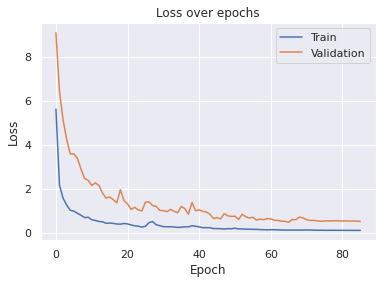

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

### **Predictions**

In [0]:
model.load_weights("best_model_5.h5")

In [0]:
predictions = model.predict([X_temporal_valid,X_demographic_valid])

Text(0, 0.5, 'Deaths')

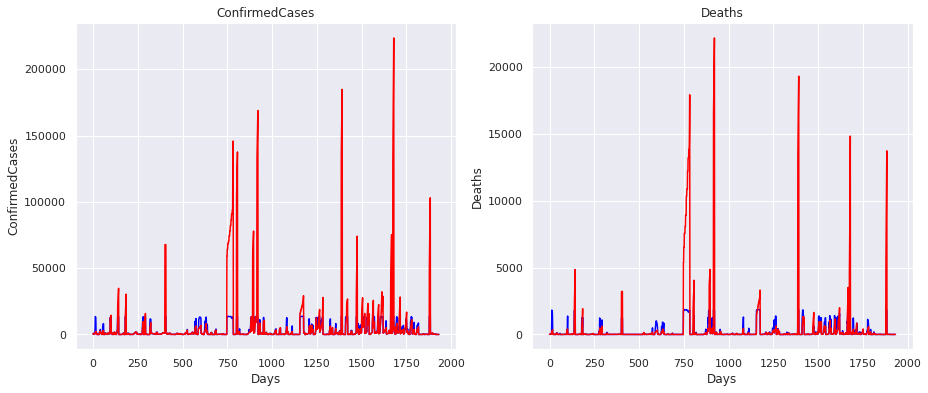

In [22]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

x=[i for i in range(len(Y_cases_valid))]
ax1.plot(x, predictions[0], color='blue')
ax1.plot(x, Y_cases_valid, color='red')
ax1.set_title("ConfirmedCases")
ax1.set_xlabel("Days")
ax1.set_ylabel("ConfirmedCases")

ax2.plot(x, predictions[1], color='blue')
ax2.plot(x, Y_fatalities_valid, color='red')
ax2.set_title("Deaths")
ax2.set_xlabel("Days")
ax2.set_ylabel("Deaths")

### **RMSE Score**

In [23]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# [X_temporal_valid,X_demographic_valid],  [Y_cases_valid, Y_fatalities_valid]
print("Confirmed cases RMSE Score", sqrt(mean_squared_error(Y_cases_valid,predictions[0])))
print("Death cases RMSE Score", sqrt(mean_squared_error(Y_fatalities_valid,predictions[1])))

Confirmed cases RMSE Score 19989.60609917064
Death cases RMSE Score 1932.212333052452


### **Sample Output**

In [159]:
display_limit = 20
for inputs, pred_cases, exp_cases, pred_fatalities, exp_fatalities in zip(X_temporal_valid,predictions[0][:display_limit], Y_cases_valid[:display_limit], predictions[1][:display_limit], Y_fatalities_valid[:display_limit]):
    print("================================================")
    print("Expected cases:", exp_cases, " Prediction:", pred_cases[0], "Expected fatalities:", exp_fatalities, " Prediction:", pred_fatalities[0] )

Expected cases: 555.0  Prediction: 574.21063 Expected fatalities: 18.0  Prediction: 18.962938
Expected cases: 840.0  Prediction: 1027.9631 Expected fatalities: 30.0  Prediction: 42.95794
Expected cases: 433.0  Prediction: 594.2339 Expected fatalities: 23.0  Prediction: 36.788757
Expected cases: 518.0  Prediction: 701.37415 Expected fatalities: 26.0  Prediction: 40.670174
Expected cases: 1825.0  Prediction: 6623.278 Expected fatalities: 275.0  Prediction: 1040.1638
Expected cases: 2268.0  Prediction: 6623.505 Expected fatalities: 348.0  Prediction: 1035.4607
Expected cases: 601.0  Prediction: 851.8743 Expected fatalities: 26.0  Prediction: 43.612045
Expected cases: 673.0  Prediction: 872.1835 Expected fatalities: 33.0  Prediction: 46.577293
Expected cases: 19.0  Prediction: 21.95654 Expected fatalities: 2.0  Prediction: 1.9358951
Expected cases: 19.0  Prediction: 21.457556 Expected fatalities: 2.0  Prediction: 1.9044373
Expected cases: 21.0  Prediction: 22.528328 Expected fatalities: 2.

### **Prediction from 17th April to 15th May**

In [0]:
# sequence_length=9
def build_inputs_for_date(country, province, date, df):
    start_date = date - timedelta(days=sequence_length)
    end_date = date - timedelta(days=1)
    
    str_start_date = start_date.strftime("%Y-%m-%d")
    str_end_date = end_date.strftime("%Y-%m-%d")
    # print(date)
    # print(str_start_date)
    # print(str_end_date)
    province_df = df.query("Country_Region=='"+country+"' and Province_State=='"+province+"' and Date>='"+str_start_date+"' and Date<='"+str_end_date+"'")
    # print(province_df.shape)
    # print(province_df['Date'])
    # print(province_df['Date'])
    #preparing the temporal inputs
    temporal_input_data = np.transpose(np.reshape(np.asarray([province_df["ConfirmedCases"],
                                                 province_df["Fatalities"],
                                                #  df["restrictions"],
                                                 province_df["quarantine"],
                                                 province_df["schools"]]),
                                     (4,sequence_length)), (1,0) ).astype(np.float32)
    
    #preparing all the demographic inputs
    temp = province_df[province_df['Date']==str_end_date]
    total_population = float(temp.total_pop)
    density = float(temp.density)
    hospibed = float(temp.hospibed)
    lung = float(temp.lung)
    centenarian_pop = float(temp["age_100+"])
    smokers_perc = float(temp.smokers_perc)
    demographic_input_data = [total_population,density,hospibed,lung,centenarian_pop, smokers_perc]
    
    return [np.array([temporal_input_data]), np.array([demographic_input_data])]

In [0]:
def predict_for_region(country, province, df, startDate, endDate):
    # begin_prediction = "2020-04-01"
    start_date = datetime.strptime(startDate,"%Y-%m-%d")
    # end_prediction = "2020-05-14"
    end_date = datetime.strptime(endDate,"%Y-%m-%d")
    
    date_list = [start_date + timedelta(days=x) for x in range((end_date-start_date).days+1)]
    for date in date_list:
        print(df.shape)
        input_data = build_inputs_for_date(country, province, date, df)
        print(df.shape)
        # print(input_data[0].shape, input_data[1].shape)
        result = model.predict(input_data)
        
        #just ensuring that the outputs is
        #higher than the previous counts
        result[0] = np.round(result[0])
        if result[0]<input_data[0][0][-1][0]:
            result[0]=np.array([[input_data[0][0][-1][0]]])
        
        result[1] = np.round(result[1])
        if result[1]<input_data[0][0][-1][1]:
            result[1]=np.array([[input_data[0][0][-1][1]]])
        print(input_data)
        #We assign the quarantine and school status
        #depending on previous values
        #e.g Once a country is locked, it will stay locked until the end
        df = df.append({"Country_Region":country, 
                        "Province_State":province, 
                        "Date":date.strftime("%Y-%m-%d"), 
                        # "restrictions": 1 if any(input_data[0][0][2]) else 0,
                        "quarantine": 1 if any(input_data[0][0][2]) else 0,
                        "schools": 1 if any(input_data[0][0][3]) else 0,
                        "total_pop": input_data[1][0],
                        "density": input_data[1][0][1],
                        "hospibed": input_data[1][0][2],
                        "lung": input_data[1][0][3],
                        "age_100+": input_data[1][0][4],
                        "ConfirmedCases":round(result[0][0][0]),	
                        "Fatalities":round(result[1][0][0])},
                       ignore_index=True)
    return df

In [179]:
# train_df = train_df.query("Date>'2020-01-22'and Date<'2020-04-01'")
copy_df = merge_dataset.query("Date>'2020-01-22'and Date<'2020-04-01'")
startDate='2020-03-18'
endDate='2020-04-15'
with tqdm(total=len(list(copy_df.Country_Region.unique()))) as pbar:
    for country in copy_df.Country_Region.unique():
        for province in copy_df.query("Country_Region=='"+country+"'").Province_State.unique():
            copy_df = predict_for_region(country, province, copy_df, startDate, endDate)
        pbar.update(1)

  0%|          | 0/313 [00:00<?, ?it/s]

(22356, 15)
(22356, 15)
[array([[[ 4.,  0.,  0.,  0.],
        [ 4.,  0.,  0.,  0.],
        [ 5.,  0.,  0.,  0.],
        [ 7.,  0.,  0.,  0.],
        [ 7.,  0.,  0.,  0.],
        [ 7.,  0.,  0.,  0.],
        [11.,  0.,  0.,  0.],
        [16.,  0.,  0.,  0.],
        [21.,  0.,  0.,  0.],
        [22.,  0.,  0.,  0.]]], dtype=float32), array([[0.02704627, 0.00227816, 0.03483495, 0.32919146, 0.00141127,
        0.21389448]])]
(22357, 15)


ValueError: ignored

In [0]:
def build_inputs_for_date1(country, province, date, df):
    start_date = date - timedelta(days=13)
    end_date = date - timedelta(days=1)
    
    str_start_date = start_date.strftime("%Y-%m-%d")
    str_end_date = end_date.strftime("%Y-%m-%d")
    df = df.query("Country_Region=='"+country+"' and Province_State=='"+province+"' and Date>='"+str_start_date+"' and Date<='"+str_end_date+"'")
    
    #preparing the temporal inputs
    temporal_input_data = np.transpose(np.reshape(np.asarray([df["ConfirmedCases"],
                                                 df["Fatalities"],
                                                 df["restrictions"],
                                                 df["quarantine"],
                                                 df["schools"]]),
                                     (5,sequence_length)), (1,0) ).astype(np.float32)
    
    #preparing all the demographic inputs
    total_population = float(province_df.iloc[i].total_pop)
    density = float(province_df.iloc[i].density)
    hospibed = float(province_df.iloc[i].hospibed)
    lung = float(province_df.iloc[i].lung)
    centenarian_pop = float(province_df.iloc[i]["age_100+"])
    demographic_input_data = [total_population,density,hospibed,lung,centenarian_pop]
    
    return [np.array([temporal_input_data]), np.array([demographic_input_data])]

In [0]:
def predict_for_region1(country, province, df):
    begin_prediction = "2020-04-01"
    start_date = datetime.strptime(begin_prediction,"%Y-%m-%d")
    end_prediction = "2020-05-14"
    end_date = datetime.strptime(end_prediction,"%Y-%m-%d")
    
    date_list = [start_date + timedelta(days=x) for x in range((end_date-start_date).days+1)]
    for date in date_list:
        input_data = build_inputs_for_date1(country, province, date, df)
        result = model.predict(input_data)
        
        #just ensuring that the outputs is
        #higher than the previous counts
        result[0] = np.round(result[0])
        if result[0]<input_data[0][0][-1][0]:
            result[0]=np.array([[input_data[0][0][-1][0]]])
        
        result[1] = np.round(result[1])
        if result[1]<input_data[0][0][-1][1]:
            result[1]=np.array([[input_data[0][0][-1][1]]])
        # print(inp)
        #We assign the quarantine and school status
        #depending on previous values
        #e.g Once a country is locked, it will stay locked until the end
        df = df.append({"Country_Region":country, 
                        "Province_State":province, 
                        "Date":date.strftime("%Y-%m-%d"), 
                        "restrictions": 1 if any(input_data[0][0][2]) else 0,
                        "quarantine": 1 if any(input_data[0][0][3]) else 0,
                        "schools": 1 if any(input_data[0][0][4]) else 0,
                        "total_pop": input_data[1][0],
                        "density": input_data[1][0][1],
                        "hospibed": input_data[1][0][2],
                        "lung": input_data[1][0][3],
                        "age_100+": input_data[1][0][4],
                        "ConfirmedCases":round(result[0][0][0]),	
                        "Fatalities":round(result[1][0][0])},
                       ignore_index=True)
    return df

In [174]:
copy_df = merge_dataset
with tqdm(total=len(list(copy_df.Country_Region.unique()))) as pbar:
    for country in copy_df.Country_Region.unique():
        for province in copy_df.query("Country_Region=='"+country+"'").Province_State.unique():
            copy_df = predict_for_region1(country, province, copy_df)
        pbar.update(1)

  0%|          | 0/313 [00:00<?, ?it/s]


KeyError: ignored

In [0]:
test_dataset = gpd.read_file("test.csv")
#The country_region got modifying in the enhanced dataset by @optimo, 
# so we have to apply the same change to the test Dataframe.
test_dataset["Country_Region"] = [ row.Country_Region if row.Province_State=="" else row.Country_Region+"_"+row.Province_State for idx,row in test_dataset.iterrows() ]
test_dataset.head()

,ForecastId,Province_State,Country_Region,Date,geometry
0,1,,Afghanistan,2020-04-02,None
1,2,,Afghanistan,2020-04-03,None
2,3,,Afghanistan,2020-04-04,None
3,4,,Afghanistan,2020-04-05,None
4,5,,Afghanistan,2020-04-06,None


In [0]:
submission_df = pd.DataFrame(columns=["ForecastId","ConfirmedCases","Fatalities"])
with tqdm(total=len(test_dataset)) as pbar:
    for idx, row in test_dataset.iterrows():
        #Had to remove single quotes because of countries like Cote D'Ivoire for example
        country_region = row.Country_Region.replace("'","").strip(" ")
        province_state = row.Province_State.replace("'","").strip(" ")
        item = copy_df.query("Country_Region=='"+country_region+"' and Province_State=='"+province_state+"' and Date=='"+row.Date+"'")
        submission_df = submission_df.append({"ForecastId":row.ForecastId,
                                              "ConfirmedCases":int(item.ConfirmedCases.values[0]),
                                              "Fatalities":int(item.Fatalities.values[0])},
                                             ignore_index=True)
        pbar.update(1)

100%|██████████| 13459/13459 [03:40<00:00, 61.16it/s]


In [0]:
submission_df.sample(20)

,ForecastId,ConfirmedCases,Fatalities
9657,9658,82,2
6743,6744,94,0
6393,6394,8306,1421
12777,12778,37,1
12767,12768,66,0
8374,8375,2068,33
3992,3993,3525,23
5239,5240,0,0
10504,10505,1570,39
10898,10899,1813,36


In [0]:
submission_df.to_csv("submission.csv",index=False)